# Hybrid Model on Snopes Dataset

The Hybrid model is created as a combination of the DeClarE model (Popat et al.,2018) and Self-Attentive Sentence Embedding model (Lin et al.,2017). This model uses the overall structure of DeClarE but replaces its attention mechanism with the Self-attention created in the second paper. The code for the Self-Attention model can be found at: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master . This code have been used as the base for the Hybrid model. Before running the code in Google Colab, please upload the config.json and model_params.json file which is provided as a part of the project code zip file. Both of these file contain the hyper-parameters of the model and were originally created by the developer of this code base.

## All Imports

In [1]:
# Most of the code of this notebook is taken from https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
# All imports
import json
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import gzip

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.utils import np_utils

from keras.optimizers import SGD, Adam
from nltk import word_tokenize
import matplotlib.pyplot as plt

import torch,keras
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as data_utils
from keras.datasets import imdb

import random, os, numpy, scipy
from codecs import open
import os,sys

Using TensorFlow backend.


In [0]:
# Random seed set to ensure that code provides the same output whenever randomisation is done.
seed = 7
np.random.seed(seed)

In [3]:
# Get the Snopes Dataset from the location provided in the DeClarE paper.
!wget http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/Snopes.zip
!unzip Snopes.zip

--2019-09-01 11:25:13--  http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/Snopes.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5559754 (5.3M) [application/zip]
Saving to: ‘Snopes.zip’

Snopes.zip          100%[===================>]   5.30M  2.49MB/s    in 2.1s    

2019-09-01 11:25:16 (2.49 MB/s) - ‘Snopes.zip’ saved [5559754/5559754]

Archive:  Snopes.zip
   creating: Snopes/
  inflating: Snopes/README           
  inflating: Snopes/snopes.tsv       


In [4]:
# Download the Glove.zip file and expand it.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2019-09-01 11:25:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-09-01 11:25:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-09-01 11:25:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## Data preperation methods

In [0]:
# This method divides the true and false data from the input dataframe and returns them as seperate dataframes
def divide_truefalse(fact):
  col = ['cred_label','claim_id','claim_text','article','article_source','bin_cred_label']
  true_data= list()
  false_data=list()
  for index, row in fact.iterrows():
    if row['cred_label'] == 'true' or row['cred_label'] == 'mostly true':
      true_data.append(row)
    else:
      false_data.append(row)

  data_frame_true = pd.DataFrame(true_data,columns=col)
  data_frame_false = pd.DataFrame(false_data,columns=col)
  return data_frame_true,data_frame_false

In [0]:
# Method to load the Snopes into the Datafarme, process it and divide it into traning and test sets.
def load_snopes():
  facts=list()
  fact=pd.read_csv('./Snopes/snopes.tsv', delimiter = '\t', names = ['cred_label','claim_id','claim_text','article','article_source'])
  
  # Convert label to binary
  claim_label = fact['cred_label']
  # The original credibility labels are -{'false', 'mostly false', 'mostly true', 'true'}
  claim_label = [1 if tuple == 'true'  or tuple == 'mostly true' else 0 for tuple in claim_label]
  fact['bin_cred_label'] = claim_label
  # Take only the top 8000
  fact_true,fact_false = divide_truefalse(fact)
  top = fact_false.head(8000)
  frame = [fact_true,top]
  fact = pd.concat(frame)
  fact = fact.reset_index(drop=True)
  claim_label = fact['cred_label']
  # Convert the labels to binary values of 0 for false and 1 for true.
  claim_label = [1 if tuple == 'true' or tuple == 'mostly true' else 0 for tuple in claim_label]
  
  # Get Train and Test sets
  input_train,input_test,label_train,label_test = train_test_split(fact, claim_label, test_size=0.2, random_state=8)
  # Convert the traning and test data as lists and return.
  train_list= list()
  train_list.append(input_train)
  train_list.append(label_train)
  
  test_list = list()
  test_list.append(input_test)
  test_list.append(label_test)
  return train_list, test_list

In [0]:
# Get Snopes dataset. This method calls the previous methods.
def load_data_set(max_len,vocab_size,batch_size):
    """
        Loads the dataset.
 
        Args:
        max_len: {int} timesteps used for padding
			  vocab_size: {int} size of the vocabulary
			  batch_size: batch_size
        """
    NUM_WORDS=vocab_size
    # Get the Snopes dataframe
    train_set,test_set = load_snopes()
    x_train,y_train = train_set[0],train_set[1]
    x_test,y_test = test_set[0],test_set[1]

    # Code to check how many unique claims are present in the test set.
    # Code found here: https://stackoverflow.com/questions/23460345/selecting-unique-rows-between-two-dataframes-in-pandas
    unique_test = x_test[~x_test['claim_text'].isin(x_train['claim_text'])]
    uniq_set = set(unique_test['claim_text'].tolist())
    print("There are %d total unique rows in the test set and %d unique claims" % (len(unique_test),len(uniq_set)))
    
    # Get the required columns as lists for both traning and test data
    art_list = x_train['article'].tolist()
    clm_list = x_train['claim_text'].tolist()
    art_src_list = x_train['article_source'].tolist()
    
    test_art_list = x_test['article'].tolist()
    test_clm_list = x_test['claim_text'].tolist()
    test_art_src_list = x_test['article_source'].tolist()
    # Text to Sequence conversion
    t = Tokenizer()
    t.fit_on_texts(clm_list+art_list+art_src_list)
    t.num_words=NUM_WORDS
    encoded_claim = t.texts_to_sequences(clm_list) # claim
    encoded_art = t.texts_to_sequences(art_list) # article
    encoded_art_src = t.texts_to_sequences(art_src_list) # article source
    
    encoded_claim_test = t.texts_to_sequences(test_clm_list)
    encoded_art_test = t.texts_to_sequences(test_art_list)
    encoded_art_src_test = t.texts_to_sequences(test_art_src_list)
    word_to_id = t.word_index
    
    # Add a padding of 150 to article and 50 to claim. Padding of 8 given to article source.
    # This is done for the training data.
    x_train_pad_cl = pad_sequences(encoded_claim, maxlen=50, padding='post') # claim padding
    x_train_pad = pad_sequences(encoded_art, maxlen=max_len, padding='post') # article padding
    x_train_pad_s = pad_sequences(encoded_art_src, maxlen=8, padding='post') # article source padding
    
    # Test padding
    x_test_pad_cl = pad_sequences(encoded_claim_test, maxlen=50, padding='post')
    x_test_pad = pad_sequences(encoded_art_test, maxlen=max_len, padding='post')
    x_test_pad_s = pad_sequences(encoded_art_src_test, maxlen=8, padding='post')
    
    # Covert training data to a Numpy array
    x_train_pad_np_cl = np.array(x_train_pad_cl, dtype=np.float32) # claim numpy
    x_train_pad_np = np.array(x_train_pad, dtype=np.float32) # article numpy
    x_train_pad_np_s = np.array(x_train_pad_s, dtype=np.float32) # article source numpy
    
    # Test data numpy
    x_test_pad_np_cl = np.array(x_test_pad_cl, dtype=np.float32)
    x_test_pad_np = np.array(x_test_pad, dtype=np.float32)
    x_test_pad_np_s = np.array(x_test_pad_s, dtype=np.float32)
    
    y_train_np = np.array(y_train, dtype=np.float32)
    y_test_np = np.array(y_test, dtype=np.float32)
    
    # Convert the training data to a Tensor Variable to be used by the Hybrid model.
    train_data = data_utils.TensorDataset(torch.from_numpy(x_train_pad_np_cl).type(torch.LongTensor),
                                          torch.from_numpy(x_train_pad_np).type(torch.LongTensor),
                                          torch.from_numpy(x_train_pad_np_s).type(torch.LongTensor),
                                          torch.from_numpy(y_train_np).type(torch.DoubleTensor))
    train_loader = data_utils.DataLoader(train_data,batch_size=batch_size,drop_last=True)
    return train_loader, x_test_pad_np_cl, x_test_pad_np, x_test_pad_np_s, y_test_np, word_to_id, x_test,x_train

In [0]:
# Get the embedding matrix using Glove.
 
vocab,word2idx = None,{}

def load_glove_embeddings(path, word2idx, embedding_dim):
    """Loading the glove embeddings"""
    vocab_size = len(word2idx) + 1
    with open(path) as f:
        embeddings = np.zeros((vocab_size, embedding_dim))
        for line in f.readlines():
            values = line.split()
            word = values[0]
            index = word2idx.get(word)
            if index:
                vector = np.array(values[1:], dtype='float32')
                if vector.shape[-1] != embedding_dim:
                    raise Exception('Dimension not matching.')
                embeddings[index] = vector
        return torch.from_numpy(embeddings).float()

In [9]:
# Method to read and store the contents of the uploaded json files.
def json_to_dict(json_set):
    for k,v in json_set.items():
        if v == 'False':
            json_set[k] = False
        elif v == 'True':
            json_set[k] = True
        else:
            json_set[k] = v
    return json_set

  
with open('config.json', 'r') as f:
    params_set = json.load(f)

with open('model_params.json', 'r') as f:
    model_params = json.load(f)

params_set = json_to_dict(params_set)
model_params = json_to_dict(model_params)
 
print("Using settings:",params_set)
print("Using model settings",model_params)

Using settings: {'epochs': 2, 'use_regularization': True, 'C': 0.03, 'clip': True, 'use_embeddings': True, 'attention_hops': 10}
Using model settings {'batch_size': 512, 'vocab_size': 20000, 'timesteps': 100, 'lstm_hidden_dimension': 50, 'd_a': 100}


In [11]:
# Call the method to load the Snopes dataset and embedding matrix
MAXLENGTH = 150
train_loader,x_test_pad_cl,x_test_pad,x_test_pad_s,y_test,word_to_id,x_test_or,x_train_or = load_data_set(MAXLENGTH,model_params["vocab_size"],model_params['batch_size']) #loading snopes dataset  

embeddings = load_glove_embeddings("glove.6B.50d.txt",word_to_id,50)

There are 87 total unique rows in the test set and 69 unique claims


## StructuredSelfAttention Model Full

In [0]:
# Structured Self Attention class. This class reprsents the Hybrid model. Most of this clas is taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
 
class StructuredSelfAttention(torch.nn.Module):
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()
        # Model layers initialization
        self.embeddings,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first.bias.data.fill_(0)
        self.linear_second = torch.nn.Linear(d_a,r)
        self.linear_second.bias.data.fill_(0)
        self.n_classes = n_classes
        
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)
        
        self.embeddings4,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        
        self.linear_penul = torch.nn.Linear(2*lstm_hid_dim,8)
        self.linear_final = torch.nn.Linear(8,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
           
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")
   
        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,ys):
        embeddings = self.embeddings(x) # claim embedding
        embeddings_part_y = self.embeddings(y[:,:100]) # article embedding, taking the first 100.
        main_embedding  = torch.cat((embeddings, embeddings_part_y), 1) # concatenation of claim and article
        # Bi-LSTM layer
        outputs, self.hidden_state = self.lstm(main_embedding.view(self.batch_size,self.max_len,-1),self.hidden_state)   
        # Self-Attention mechanism
        x = torch.tanh(self.linear_first(outputs))       
        x = self.linear_second(x)       
        x = self.softmax(x,1)       
        attention = x.transpose(1,2)  
        sentence_embeddings = attention@outputs
        
        # The same mechanim doen for the Article only input
        embeddings2 = self.embeddings2(y)    
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)       
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        # Combine the output of the two Self-Attentions
        ele_mul = sentence_embeddings * sentence_embeddings2
        # Take an average
        avg_sentence_embeddings = torch.sum(ele_mul,1)/self.r
        # Create embedding for article source
        embeddings4 = self.embeddings4(ys) 
        # Take average
        avg_asource_embeddings = torch.sum(embeddings4,1)/self.r
        # Combine with the average of the Sef-attention outputs.
        comb_avg = torch.cat((avg_sentence_embeddings, avg_asource_embeddings), 1)
        dense1 = self.linear_penul(comb_avg) 
        output = torch.sigmoid(self.linear_final(dense1))
        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [0]:
# Training function that applies the penalization. Most of this code is taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
 
def train(attention_model,train_loader,criterion,optimizer,epochs = 5,use_regularization = False,C=0,clip=False):
    """
        Training code
 
        Args:
            attention_model : {object} model
            train_loader    : {DataLoader} training data loaded into a dataloader
            optimizer       :  optimizer
            criterion       :  loss function. Must be BCELoss for binary_classification and NLLLoss for multiclass
            epochs          : {int} number of epochs
            use_regularizer : {bool} use penalization or not
            C               : {int} penalization coeff
            clip            : {bool} use gradient clipping or not
       
        Returns:
            accuracy and losses of the model
      
        """
    losses = []
    accuracy = []
    for i in range(epochs):
        print("Running EPOCH",i+1)
        total_loss = 0
        n_batches = 0
        correct = 0
        
        for batch_idx,train in enumerate(train_loader):
            attention_model.hidden_state = attention_model.init_hidden()
            x,x2,x2s,y = Variable(train[0]),Variable(train[1]),Variable(train[2]),Variable(train[3])
            y_pred,att = attention_model(x,x2,x2s)
            
            #penalization AAT - I
            if use_regularization:
                attT = att.transpose(1,2)
                identity = torch.eye(att.size(1))
                identity = Variable(identity.unsqueeze(0).expand(train_loader.batch_size,att.size(1),att.size(1)))
                penal = attention_model.l2_matrix_norm(att@attT - identity)
            
            if not bool(attention_model.type) :
                #binary classification
                #Adding a very small value to prevent BCELoss from outputting NaN's
                correct+=torch.eq(torch.round(y_pred.type(torch.DoubleTensor).squeeze(1)),y).data.sum()
                if use_regularization:
                    try:
                        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(1)+1e-8,y) + C * penal/train_loader.batch_size
                        
                    except RuntimeError:
                        raise Exception("BCELoss gets nan values on regularization. Either remove regularization or add very small values")
                else:
                    loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(1),y)

            total_loss+=loss.data
            optimizer.zero_grad()
            loss.backward()
            
            #gradient clipping
            if clip:
                torch.nn.utils.clip_grad_norm_(attention_model.parameters(),0.5)
            optimizer.step()
            n_batches+=1
        
        print("avg_loss is",total_loss/n_batches)
        corr_nump = correct.data.cpu().numpy().astype(int)
        acc = corr_nump/float(n_batches*train_loader.batch_size)
        print("Accuracy of the model",acc)
        losses.append(total_loss/n_batches)
        accuracy.append(acc)
    return losses,accuracy

# Evaluate the test result and return the accuracy and the predicted values
def evaluate(attention_model,x_test_cl,x_test,x_test_s,y_test):
    
    attention_model.batch_size = x_test.shape[0]
    attention_model.hidden_state = attention_model.init_hidden()
    
    x_test_var = Variable(torch.from_numpy(x_test).type(torch.LongTensor)) # article var
    x_test_var_cl = Variable(torch.from_numpy(x_test_cl).type(torch.LongTensor)) # claim var
    x_test_var_s = Variable(torch.from_numpy(x_test_s).type(torch.LongTensor)) # article source var
    y_test_pred,_ = attention_model(x_test_var_cl,x_test_var,x_test_var_s)

    y_preds = torch.round(y_test_pred.type(torch.DoubleTensor).squeeze(1))
    y_test_var = Variable(torch.from_numpy(y_test).type(torch.DoubleTensor))
    sum = torch.eq(y_preds,y_test_var).data.sum()
    total = x_test_var.size(0)
    acc = sum.data.cpu().numpy().astype(int)/float(total)
    return acc, y_preds

def get_activation_wts(attention_model,x,y,ys):
    """
        Get r attention heads
 
        Args:
            attention_model : {object} model
            x               : {torch.Variable} input whose weights we want (claim)
            y               : {torch.Variable} the second input (article)
       
        Returns:
            r different attention weights
 
      
    """
    attention_model.batch_size = x.size(0)
    attention_model.hidden_state = attention_model.init_hidden()
    _,wts = attention_model(x,y,ys)
    return wts

In [0]:
#Creates and HTML file which show the attention weights visulaization on the article. This code taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
 
def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
	weights: attention weights for visualizing
	texts: text on which attention weights are to be visualized
    """
    fileName = "visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="en">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = "";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>" + space + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return

In [0]:
# Create a new directory called visualization.
!mkdir visualization

## Model execution

In [0]:
#Method to process the article and the attention weights then create the HTML file.
def visualize_attention(wts,x_test_pad,word_to_id,filename):
    wts_add = torch.sum(wts,1)
    wts_add_np = wts_add.data.numpy()
    wts_add_list = wts_add_np.tolist()
    id_to_word = {v:k for k,v in word_to_id.items()}
    text= []
    for test in x_test_pad:
        line=list()
        for i in test:
          if i == 0.0:
            word = '<UNK>'
          else:
            word = id_to_word.get(i)
          line.append(word)
        text.append(" ".join(line))
    createHTML(text, wts_add_list, filename)
    print("Attention visualization created for {} samples".format(len(x_test_pad)))
    return
# Method to perform the classification using Binary Cross Entropy Loss and RMSProp optimizer
def binary_classfication(attention_model,train_loader,epochs=5,use_regularization=True,C=1.0,clip=True):
    loss = torch.nn.BCELoss()
    optimizer = torch.optim.RMSprop(attention_model.parameters())
    loss,accuracy=train(attention_model,train_loader,loss,optimizer,epochs,use_regularization,C,clip)
    return loss, accuracy

In [17]:
# Model execution
attention_model = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model,train_loader=train_loader,epochs=3,use_regularization=True,C=params_set["C"],clip=params_set["clip"])

Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.7570, dtype=torch.float64)
Accuracy of the model 0.6172688802083334
Running EPOCH 2
avg_loss is tensor(0.2156, dtype=torch.float64)
Accuracy of the model 0.9462890625
Running EPOCH 3
avg_loss is tensor(0.0863, dtype=torch.float64)
Accuracy of the model 0.98828125


In [18]:
# Accuracy of the test data
acc, pred = evaluate(attention_model, x_test_pad_cl, x_test_pad, x_test_pad_s, y_test)
print(acc)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9832366215344939


In [0]:
# Method to plot the confusion matrix. Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['False','True'], yticklabels=['False','True'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[1586   20]
 [  32 1464]]
Normalized confusion matrix
[[0.9875467  0.0124533 ]
 [0.02139037 0.97860963]]


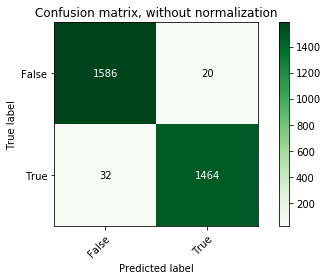

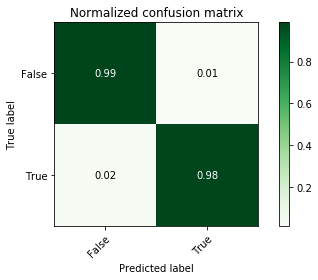

In [20]:
plot_confusion_matrix(y_test,pred.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred.detach().numpy(),[0,1], normalize=True)

In [0]:
# Code taken from Lab5 of TaD. This method returns the accuarcy, precision, recall and F1 measure values for an input.
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))
  return precision,recall,accuracy,f1 

In [22]:
basic_p,basc_r,basic_a,basic_f1 = evaluation_summary("Self Attention-Full", pred.detach().numpy(), y_test)

Evaluation for: Self Attention-Full
Classifier 'Self Attention-Full' has Acc=0.983 P=0.983 R=0.983 F1=0.983
              precision    recall  f1-score   support

         0.0      0.988     0.980     0.984      1618
         1.0      0.979     0.987     0.983      1484

    accuracy                          0.983      3102
   macro avg      0.983     0.983     0.983      3102
weighted avg      0.983     0.983     0.983      3102


Confusion matrix:
 [[1586   20]
 [  32 1464]]


In [23]:
# Calculate the AUC value of the result.
fpr, tpr, thresholds = roc_curve(y_test, pred.detach().numpy())
auc_basic = auc(fpr, tpr)
print("Self Attention-Full AUC-",auc_basic)

Self Attention-Full AUC- 0.983078162771958


In [24]:
# Visualize the attention weights for this model.
test_last_idx = 15
wts = get_activation_wts(attention_model,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
visualize_attention(wts,x_test_pad[:test_last_idx],word_to_id,filename='attention_full.html')

Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Sub-Model: Self Attention model using only Article and Claim

In [0]:
# Same model but it uses only article and claim as input. 
 
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()
        # Initialization of the required layers
        self.embeddings,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first.bias.data.fill_(0)
        self.linear_second = torch.nn.Linear(d_a,r)
        self.linear_second.bias.data.fill_(0)
        self.n_classes = n_classes
        
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)
        
        self.linear_final = torch.nn.Linear(lstm_hid_dim,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
          
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")
        
        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,ys):
        embeddings = self.embeddings(x) # claim embedding
        embeddings_part_y = self.embeddings(y[:,:100]) # article embedding taking the first 100 values
        main_embedding  = torch.cat((embeddings, embeddings_part_y), 1) # combination of the two
        # BI-LSTM layer
        outputs, self.hidden_state = self.lstm(main_embedding.view(self.batch_size,self.max_len,-1),self.hidden_state)
        # Self-Attention mechanism 
        x = torch.tanh(self.linear_first(outputs))       
        x = self.linear_second(x)       
        x = self.softmax(x,1)       
        attention = x.transpose(1,2)  
        sentence_embeddings = attention@outputs
        # Same processing followed for article only.
        embeddings2 = self.embeddings2(y)    
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)       
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        # element-wise multiplication of the two outputs.
        ele_mul = sentence_embeddings * sentence_embeddings2
        # Average of the output.
        avg_sentence_embeddings = torch.sum(ele_mul,1)/self.r
        
        output = torch.sigmoid(self.linear_final(avg_sentence_embeddings))

        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [46]:
# Initialize and Train the model.
attention_model2 = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model2,train_loader=train_loader,epochs=3,use_regularization=True,C=params_set["C"],clip=params_set["clip"])


Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.7340, dtype=torch.float64)
Accuracy of the model 0.6321614583333334
Running EPOCH 2
avg_loss is tensor(0.2139, dtype=torch.float64)
Accuracy of the model 0.957763671875
Running EPOCH 3
avg_loss is tensor(0.0974, dtype=torch.float64)
Accuracy of the model 0.9927571614583334


In [47]:
# Accuracy of the test data
acc2, pred2 = evaluate(attention_model2, x_test_pad_cl, x_test_pad, x_test_pad_s, y_test)
print(acc2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9871050934880722


Confusion matrix, without normalization
[[1587   19]
 [  21 1475]]
Normalized confusion matrix
[[0.98816936 0.01183064]
 [0.01403743 0.98596257]]


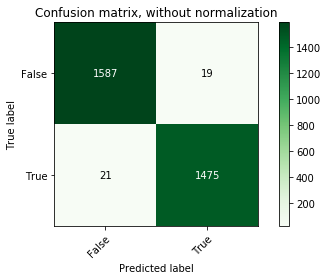

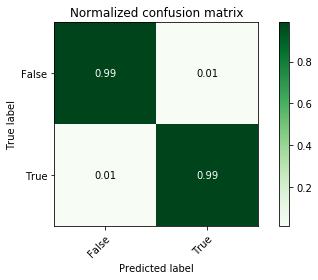

In [48]:
plot_confusion_matrix(y_test,pred2.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred2.detach().numpy(),[0,1], normalize=True)

In [49]:
art_cl_p,art_cl_r,art_cl_a,art_cl_f1 = evaluation_summary("Self Attention-Article and Claim", pred2.detach().numpy(), y_test)

Evaluation for: Self Attention-Article and Claim
Classifier 'Self Attention-Article and Claim' has Acc=0.987 P=0.987 R=0.987 F1=0.987
              precision    recall  f1-score   support

         0.0      0.988     0.987     0.988      1608
         1.0      0.986     0.987     0.987      1494

    accuracy                          0.987      3102
   macro avg      0.987     0.987     0.987      3102
weighted avg      0.987     0.987     0.987      3102


Confusion matrix:
 [[1587   19]
 [  21 1475]]


In [50]:
fpr, tpr, thresholds = roc_curve(y_test, pred2.detach().numpy())
auc_art_cl = auc(fpr, tpr)
print("Self Attention-Article_claim AUC-",auc_art_cl)

Self Attention-Article_claim AUC- 0.9870659658633066


In [51]:
# Visulaisation
test_last_idx = 15
wts2 = get_activation_wts(attention_model2,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
print(wts2.size())
visualize_attention(wts2,x_test_pad[:test_last_idx],word_to_id,filename='attention_art_cl.html')

torch.Size([15, 10, 150])
Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


##Sub Model- Using only Article

In [0]:
# Self attention class this time only using the Article.
 
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()
        self.n_classes = n_classes
        
        # Self Attention layers for Article
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)
        
        self.linear_final = torch.nn.Linear(lstm_hid_dim,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
          
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")
        
        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,ys):
        # Article embedding
        embeddings2 = self.embeddings2(y)   
        # Bi-LSTM layer 
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state)      
        # Self-Attention mechanism 
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        # Average of the output.
        avg_sentence_embeddings = torch.sum(sentence_embeddings2,1)/self.r

        output = torch.sigmoid(self.linear_final(avg_sentence_embeddings))

        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [0]:
# Initialize and train the model
attention_model3 = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model3,train_loader=train_loader,epochs=3,use_regularization=True,C=params_set["C"],clip=params_set["clip"])


Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.7992, dtype=torch.float64)
Accuracy of the model 0.603515625
Running EPOCH 2
avg_loss is tensor(0.3817, dtype=torch.float64)
Accuracy of the model 0.8905436197916666
Running EPOCH 3
avg_loss is tensor(0.1924, dtype=torch.float64)
Accuracy of the model 0.9679361979166666


In [0]:
# Accuracy of the test data
acc3, pred3 = evaluate(attention_model3, x_test_pad_cl, x_test_pad, x_test_pad_s, y_test)
print(acc3)

0.8668600902643456


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Confusion matrix, without normalization
[[1309  339]
 [  74 1380]]
Normalized confusion matrix
[[0.79429612 0.20570388]
 [0.05089409 0.94910591]]


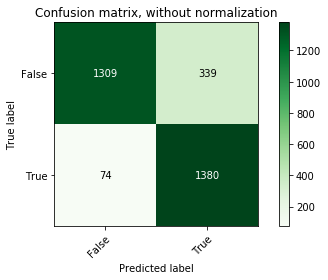

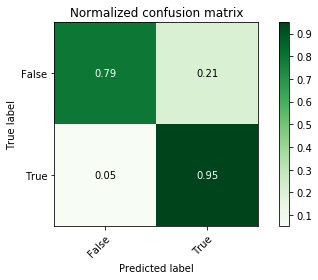

In [0]:
plot_confusion_matrix(y_test,pred3.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred3.detach().numpy(),[0,1], normalize=True)

In [0]:
art_p,art_r,art_a,art_f1 = evaluation_summary("Self Attention-Article only", pred3.detach().numpy(), y_test)

Evaluation for: Self Attention-Article only
Classifier 'Self Attention-Article only' has Acc=0.867 P=0.872 R=0.875 F1=0.867
              precision    recall  f1-score   support

         0.0      0.794     0.946     0.864      1383
         1.0      0.949     0.803     0.870      1719

    accuracy                          0.867      3102
   macro avg      0.872     0.875     0.867      3102
weighted avg      0.880     0.867     0.867      3102


Confusion matrix:
 [[1309  339]
 [  74 1380]]


In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred3.detach().numpy())
auc_art = auc(fpr, tpr)
print("Self Attention-Article only AUC-",auc_art)

Self Attention-Article only AUC- 0.8717010156114369


In [0]:
# Visulaisation
test_last_idx = 15
wts3 = get_activation_wts(attention_model3,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
print(wts3.size())
visualize_attention(wts3,x_test_pad[:test_last_idx],word_to_id,filename='attention_art.html')

torch.Size([15, 10, 150])
Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Sub Model- Article and sources

In [0]:
# Self attention class uing only the article and article source
 
class StructuredSelfAttention(torch.nn.Module):
    """
    The class is an implementation of the paper A Structured Self-Attentive Sentence Embedding including regularization
    and without pruning. Slight modifications have been done for speedup
    """
    def __init__(self,batch_size,lstm_hid_dim,d_a,r,max_len,emb_dim=100,vocab_size=None,use_pretrained_embeddings = False,embeddings=None,type= 0,n_classes = 1):
        """
        Initializes parameters suggested in paper
 
        Args:
            batch_size  : {int} batch_size used for training
            lstm_hid_dim: {int} hidden dimension for lstm
            d_a         : {int} hidden dimension for the dense layer
            r           : {int} attention-hops or attention heads
            max_len     : {int} number of lstm timesteps
            emb_dim     : {int} embeddings dimension
            vocab_size  : {int} size of the vocabulary
            use_pretrained_embeddings: {bool} use or train your own embeddings
            embeddings  : {torch.FloatTensor} loaded pretrained embeddings
            type        : [0,1] 0-->binary_classification 1-->multiclass classification
            n_classes   : {int} number of classes
 
        Returns:
            self
 
        Raises:
            Exception
        """
        super(StructuredSelfAttention,self).__init__()
        self.n_classes = n_classes
        
        # Self Attention layers for Article
        self.embeddings2,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        self.lstm2 = torch.nn.LSTM(emb_dim,lstm_hid_dim,1,batch_first=True)
        self.linear_first2 = torch.nn.Linear(lstm_hid_dim,d_a)
        self.linear_first2.bias.data.fill_(0)
        self.linear_second2 = torch.nn.Linear(d_a,r)
        self.linear_second2.bias.data.fill_(0)
        
         # Embedding layers for sources
        self.embeddings4,emb_dim = self._load_embeddings(use_pretrained_embeddings,embeddings,vocab_size,emb_dim)
        
        self.linear_final = torch.nn.Linear(2*lstm_hid_dim,self.n_classes)
        self.batch_size = batch_size       
        self.max_len = max_len
        self.lstm_hid_dim = lstm_hid_dim
        self.hidden_state = self.init_hidden()
        self.r = r
        self.type = type
                 
    def _load_embeddings(self,use_pretrained_embeddings,embeddings,vocab_size,emb_dim):
        """Load the embeddings based on flag"""
        if use_pretrained_embeddings is True and embeddings is None:
            raise Exception("Send a pretrained word embedding as an argument")
          
        if not use_pretrained_embeddings and vocab_size is None:
            raise Exception("Vocab size cannot be empty")
        
        if not use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(vocab_size,emb_dim,padding_idx=0)
            
        elif use_pretrained_embeddings:
            word_embeddings = torch.nn.Embedding(embeddings.size(0), embeddings.size(1))
            word_embeddings.weight = torch.nn.Parameter(embeddings)
            emb_dim = embeddings.size(1)
            
        return word_embeddings,emb_dim
       
        
    def softmax(self,input, axis=1):
        """
        Softmax applied to axis=n
 
        Args:
           input: {Tensor,Variable} input on which softmax is to be applied
           axis : {int} axis on which softmax is to be applied
 
        Returns:
            softmaxed tensors
 
       
        """
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size)-1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = F.softmax(input_2d)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size)-1)
       
        
    def init_hidden(self):
        return (Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)),Variable(torch.zeros(1,self.batch_size,self.lstm_hid_dim)))
       
        
    def forward(self,x,y,ys):
        # Article embedding
        embeddings2 = self.embeddings2(y)    
        # Bi-LSTM layer 
        outputs2, self.hidden_state2 = self.lstm2(embeddings2.view(self.batch_size,self.max_len,-1),self.hidden_state) 
        # Self-Attention mechanism      
        x2 = torch.tanh(self.linear_first2(outputs2))       
        x2 = self.linear_second2(x2)       
        x2 = self.softmax(x2,1)       
        attention2 = x2.transpose(1,2)       
        sentence_embeddings2 = attention2@outputs2
        # Average of the output.
        avg_sentence_embeddings = torch.sum(sentence_embeddings2,1)/self.r
        # Article source embedding
        embeddings4 = self.embeddings4(ys) 
        
        avg_asource_embeddings = torch.sum(embeddings4,1)/self.r
        # Combined average of the source and self-attention outputs.
        comb_avg = torch.cat((avg_sentence_embeddings, avg_asource_embeddings), 1)

        output = torch.sigmoid(self.linear_final(comb_avg))
        return output,attention2
        
    #Regularization
    def l2_matrix_norm(self,m):
        """
        Frobenius norm calculation
 
        Args:
           m: {Variable} ||AAT - I||
 
        Returns:
            regularized value
 
       
        """
        return torch.sum(torch.sum(torch.sum(m**2,1),1)**0.5).type(torch.DoubleTensor)

In [0]:
# Initialize and Train the model
attention_model4 = StructuredSelfAttention(batch_size=train_loader.batch_size,lstm_hid_dim=model_params['lstm_hidden_dimension'],d_a = model_params["d_a"],r=params_set["attention_hops"],vocab_size=len(word_to_id),max_len=MAXLENGTH,type=0,n_classes=1,use_pretrained_embeddings=True,embeddings=embeddings)

loss, acc = binary_classfication(attention_model4,train_loader=train_loader,epochs=3,use_regularization=False,C=params_set["C"],clip=params_set["clip"])


Running EPOCH 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


avg_loss is tensor(0.7028, dtype=torch.float64)
Accuracy of the model 0.606201171875
Running EPOCH 2
avg_loss is tensor(0.2535, dtype=torch.float64)
Accuracy of the model 0.91357421875
Running EPOCH 3
avg_loss is tensor(0.1169, dtype=torch.float64)
Accuracy of the model 0.9659016927083334


In [0]:
# Accuracy of the test data
acc4, pred4 = evaluate(attention_model4, x_test_pad_cl, x_test_pad, x_test_pad_s, y_test)
print(acc4)

0.8629916183107672


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Confusion matrix, without normalization
[[1361  287]
 [ 138 1316]]
Normalized confusion matrix
[[0.82584951 0.17415049]
 [0.09491059 0.90508941]]


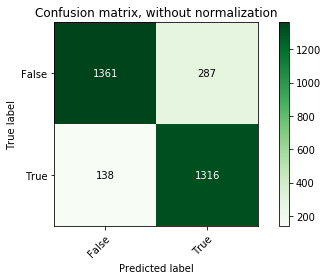

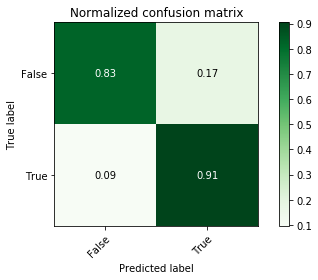

In [0]:
plot_confusion_matrix(y_test,pred4.detach().numpy(),[0,1])
plot_confusion_matrix(y_test,pred4.detach().numpy(),[0,1], normalize=True)

In [0]:
arts_p,arts_r,arts_a,arts_f1 = evaluation_summary("Self Attention-Article and sources", pred4.detach().numpy(), y_test)

Evaluation for: Self Attention-Article and sources
Classifier 'Self Attention-Article and sources' has Acc=0.863 P=0.865 R=0.864 F1=0.863
              precision    recall  f1-score   support

         0.0      0.826     0.908     0.865      1499
         1.0      0.905     0.821     0.861      1603

    accuracy                          0.863      3102
   macro avg      0.865     0.864     0.863      3102
weighted avg      0.867     0.863     0.863      3102


Confusion matrix:
 [[1361  287]
 [ 138 1316]]


In [0]:
fpr, tpr, thresholds = roc_curve(y_test, pred4.detach().numpy())
auc_arts = auc(fpr, tpr)
print("Self Attention-Article_souces AUC-",auc_arts)

Self Attention-Article_souces AUC- 0.8654694615456525


In [0]:
# Visulaisation
test_last_idx = 15
wts4 = get_activation_wts(attention_model4,Variable(torch.from_numpy(x_test_pad_cl[:test_last_idx]).type(torch.LongTensor)),
                             Variable(torch.from_numpy(x_test_pad[:test_last_idx]).type(torch.LongTensor)),
                        Variable(torch.from_numpy(x_test_pad_s[:test_last_idx]).type(torch.LongTensor)))
print(wts4.size())
visualize_attention(wts4,x_test_pad[:test_last_idx],word_to_id,filename='attention_art_sources.html')

torch.Size([15, 10, 150])
Attention visualization created for 15 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Test for Unique Claims

Due to the problem of experimental bias introduced into the model, we test the performance of the Hybrid model on unique claims. This bias is introduced because a claim can be associated with many articles and hence can be repeated in traning and test data making it seen data for the model when testing.

In [25]:
 #For full model
x_test_or['pred_label_full'] = pred.detach().numpy()
unique_test_or2 = x_test_or[~x_test_or['claim_text'].isin(x_train_or['claim_text'])]
unique_test_or2.head()

,cred_label,claim_id,claim_text,article,article_source,bin_cred_label,pred_label_full
6157,true,holidays_christmas_photos_decorations,photograph shows holiday display depicting hom...,the legends information and misinformation tha...,www.sjpba.net,1,1.0
23491,mostly true,trayvon-martin-space-camp,photograph shows shooting victim trayvon marti...,read more false george zimmerman found dead fo...,hoax.trendolizer.com,1,0.0
9511,true,politics_war_onleave,civilians give seats commercial flight soldier...,offline quote quick reply remove advertisement...,www.puff.com,1,1.0
5648,true,humor_mediagoofs_sixpence2,urban myths board game fell joke using nursery...,a true legend a red indicates a false one and ...,www.j-dubbstheater.com,1,1.0
27614,true,politics_obama_photos_crashers,photograph shows barack obama posing couple cr...,comment culture travel life women fashion luxu...,www.telegraph.co.uk,1,1.0


In [0]:
bin_pred2=unique_test_or2['bin_cred_label'].tolist()
pred_val2=unique_test_or2['pred_label_full'].tolist()

Confusion matrix, without normalization
[[18 17]
 [16 36]]
Normalized confusion matrix
[[0.51428571 0.48571429]
 [0.30769231 0.69230769]]


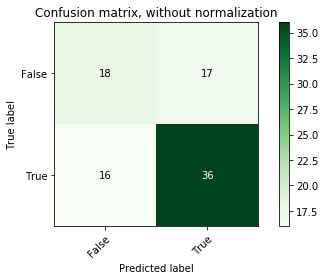

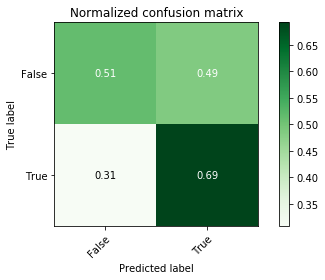

In [27]:
plot_confusion_matrix(bin_pred2,pred_val2,[0,1])
plot_confusion_matrix(bin_pred2,pred_val2,[0,1], normalize=True)

In [28]:
ac_p,ac_r,ac_a,ac_f1 = evaluation_summary("Self Attention-article and claim", pred_val2, bin_pred2)

Evaluation for: Self Attention-article and claim
Classifier 'Self Attention-article and claim' has Acc=0.621 P=0.603 R=0.604 F1=0.604
              precision    recall  f1-score   support

         0.0      0.514     0.529     0.522        34
         1.0      0.692     0.679     0.686        53

    accuracy                          0.621        87
   macro avg      0.603     0.604     0.604        87
weighted avg      0.623     0.621     0.622        87


Confusion matrix:
 [[18 17]
 [16 36]]


In [29]:
fpr, tpr, thresholds = roc_curve(bin_pred2, pred_val2)
auc_arts = auc(fpr, tpr)
print("Self Attention-Article_souces AUC-",auc_arts)

Self Attention-Article_souces AUC- 0.6032967032967033


In [30]:
label_counts = unique_test_or2['bin_cred_label'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(5)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count     2.000000
mean     43.500000
std      12.020815
min      35.000000
25%      39.250000
50%      43.500000
75%      47.750000
max      52.000000
Name: bin_cred_label, dtype: float64
1    52
0    35
Name: bin_cred_label, dtype: int64


In [52]:
incorrect2 = unique_test_or2[unique_test_or2['bin_cred_label']!=unique_test_or2['pred_label_full'].astype(int)]
incorrect2

,cred_label,claim_id,claim_text,article,article_source,bin_cred_label,pred_label_full
23491,mostly true,trayvon-martin-space-camp,photograph shows shooting victim trayvon marti...,read more false george zimmerman found dead fo...,hoax.trendolizer.com,1,0.0
7714,false,holidays_flagday_burnflag,flag protocol specifies us flag burned allowed...,so little compared to conventional treatment t...,la-compagnie-noire.com,0,1.0
19336,true,critters_gnus_jumboluv,village india learned hard way not interfere c...,is the breakup month for couples the visual ap...,matthewenglish1.blogspot.com,1,0.0
2150,true,photos_people_heritage,photograph shows white supremacist activist su...,of a portuguese farmhouse 0 0 24 carrot eyesig...,camelopardid2.rssing.com,1,0.0
15823,true,politics_soapbox_wakeup,naval captains speech urges americans wake act...,headlines about world 16 dan ouimette essay na...,www.briefguru.com,1,0.0
911,false,rumors_burqacell,antiterrorism presentation describes suspiciou...,area multiple listing service reo real estate ...,ndfhgss4.awardspace.biz,0,1.0
12600,true,risque_tattled_chung,employee south korean firm gets fired email br...,it s sent down the alimentary canal it s no mo...,snarkypants.com,1,0.0
5465,false,photos_architecture_belairmansion,photographs show mansion belonging filipino se...,mugabe go log in create a blog help conditions...,lengthphotos.indexbuzz.net,0,1.0
4495,false,horrors_robbery_purse,women wear purses strapped across bodies runni...,tale is to serve to keep kids safe without the...,www.ruthenia.ru,0,1.0
28247,true,photos_animals_electrocutedbear,photographs show brown bear electrocuted chewe...,images from up newt the bear and the bow and d...,consteb9.reunionwatch.com,1,0.0


In [0]:
# Write to csv
unique_test_or2.to_csv('op_attn_snope_full.csv', sep='\t')

In [53]:
# For Article_claim model
x_test_or['pred_label2'] = pred2.detach().numpy()
unique_test_or3 = x_test_or[~x_test_or['claim_text'].isin(x_train_or['claim_text'])]
unique_test_or3.head()

,cred_label,claim_id,claim_text,article,article_source,bin_cred_label,pred_label2
6157,true,holidays_christmas_photos_decorations,photograph shows holiday display depicting hom...,the legends information and misinformation tha...,www.sjpba.net,1,1.0
23491,mostly true,trayvon-martin-space-camp,photograph shows shooting victim trayvon marti...,read more false george zimmerman found dead fo...,hoax.trendolizer.com,1,0.0
9511,true,politics_war_onleave,civilians give seats commercial flight soldier...,offline quote quick reply remove advertisement...,www.puff.com,1,1.0
5648,true,humor_mediagoofs_sixpence2,urban myths board game fell joke using nursery...,a true legend a red indicates a false one and ...,www.j-dubbstheater.com,1,1.0
27614,true,politics_obama_photos_crashers,photograph shows barack obama posing couple cr...,comment culture travel life women fashion luxu...,www.telegraph.co.uk,1,1.0


In [0]:
bin_pred3=unique_test_or3['bin_cred_label'].tolist()
pred_val3=unique_test_or3['pred_label2'].tolist()

Confusion matrix, without normalization
[[19 16]
 [15 37]]
Normalized confusion matrix
[[0.54285714 0.45714286]
 [0.28846154 0.71153846]]


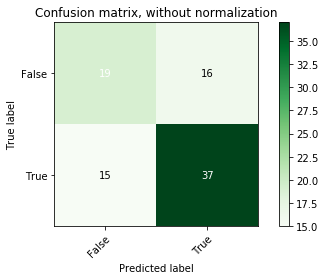

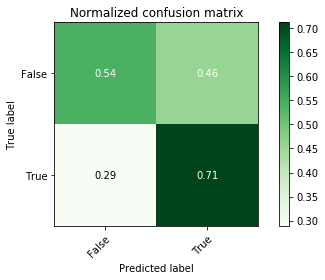

In [55]:
plot_confusion_matrix(bin_pred3,pred_val3,[0,1])
plot_confusion_matrix(bin_pred3,pred_val3,[0,1], normalize=True)

In [56]:
ac_p,ac_r,ac_a,ac_f1 = evaluation_summary("Self Attention-article and claim", pred_val3, bin_pred3)

Evaluation for: Self Attention-article and claim
Classifier 'Self Attention-article and claim' has Acc=0.644 P=0.627 R=0.628 F1=0.628
              precision    recall  f1-score   support

         0.0      0.543     0.559     0.551        34
         1.0      0.712     0.698     0.705        53

    accuracy                          0.644        87
   macro avg      0.627     0.628     0.628        87
weighted avg      0.646     0.644     0.645        87


Confusion matrix:
 [[19 16]
 [15 37]]


In [57]:
fpr, tpr, thresholds = roc_curve(bin_pred3, pred_val3)
auc_arts = auc(fpr, tpr)
print("Self Attention-Article_souces AUC-",auc_arts)

Self Attention-Article_souces AUC- 0.6271978021978023


In [58]:
label_counts = unique_test_or3['bin_cred_label'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(5)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count     2.000000
mean     43.500000
std      12.020815
min      35.000000
25%      39.250000
50%      43.500000
75%      47.750000
max      52.000000
Name: bin_cred_label, dtype: float64
1    52
0    35
Name: bin_cred_label, dtype: int64


In [59]:
incorrect3 = unique_test_or2[unique_test_or3['bin_cred_label']!=unique_test_or3['pred_label2'].astype(int)]
incorrect3

,cred_label,claim_id,claim_text,article,article_source,bin_cred_label,pred_label_full
23491,mostly true,trayvon-martin-space-camp,photograph shows shooting victim trayvon marti...,read more false george zimmerman found dead fo...,hoax.trendolizer.com,1,0.0
11225,true,politics_war_magazine,saddam hussein owned part number popular magaz...,i would not necessarily count on it the future...,www.cnn.com,1,1.0
7870,false,glurge_police,virginia state trooper expresses frustration p...,which is a lincoln quote i never had a policy ...,www.bayarearidersforum.com,0,0.0
8932,false,media_notnews_piranha,six college students arrested released piranha...,after teenager ejaculates in pool transgender ...,worldnewsdailyreport.com,0,0.0
7714,false,holidays_flagday_burnflag,flag protocol specifies us flag burned allowed...,so little compared to conventional treatment t...,la-compagnie-noire.com,0,1.0
19336,true,critters_gnus_jumboluv,village india learned hard way not interfere c...,is the breakup month for couples the visual ap...,matthewenglish1.blogspot.com,1,0.0
15823,true,politics_soapbox_wakeup,naval captains speech urges americans wake act...,headlines about world 16 dan ouimette essay na...,www.briefguru.com,1,0.0
7247,false,politics_guns_baseballbats,homicides us committed baseball bats firearms,edit administration rescue by tags common sens...,www.dailykos.com,0,0.0
4135,false,critters_crusader_greyhounds,dogs not adopted closure dairyland greyhound p...,paste this link tag into your web page or blog...,www.highbeam.com,0,0.0
11224,true,politics_war_magazine,saddam hussein owned part number popular magaz...,beating this thing pm 8 registered user join d...,www.camaroz28.com,1,1.0


In [0]:
# Write to csv
unique_test_or3.to_csv('op_attn_snope_artcl.csv', sep='\t')

## Bibliography
Kashyap Popat, Subhabrata Mukherjee, Andrew Yates and Gerhard Weikum, <i>DeClarE: Debunking Fake News and False Claims using Evidence-Aware Deep Learning</i>, Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, Pages 22-32, 2018.

Zhouhan Lin,  Minwei Feng, Cicero Nogueira dos Santos, Mo Yu, Bing Xiang, Bowen Zhou and Yoshua Bengio,<i> A Structured Self-attentive Sentence Embedding</i>, ICLR, 2017.